<a href="https://colab.research.google.com/github/arjunsekhon/python/blob/master/MovieRecommenderSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Recommendation System**

**Project Outline**

This project is broken down into 7 steps:

1.   Importing the packages
2.   Loading the data
3.   Exploratory data analysis
4.   Data pre-processing
5.   Collaborative filtering using k-Nearest Neighbors
6.   Handling the cold-start problem with content-based filtering
7.   Dimensionality reduction with matrix factorization


# Step 1: Import Packages

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load the MovieLens Dataset

Download `ml-latest-small.zip` from this website https://grouplens.org/datasets/movielens/ and load these files
*   ratings.csv
*   movies.csv


In [19]:
ratings = pd.read_csv('ratings.csv')

In [20]:
movies = pd.read_csv('movies.csv')

# Step 3: Exploratory Data Analysis


In [21]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


**What is the distribution of movie ratings?**

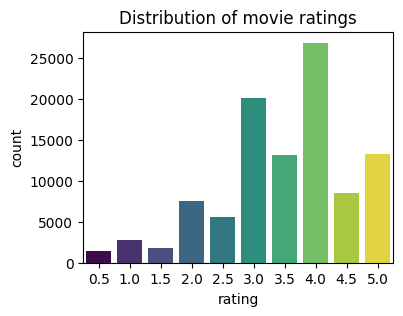

In [22]:
plt.figure(figsize=(4, 3))
sns.countplot(x="rating", data=ratings, palette="viridis", hue='rating', legend=False)
plt.title("Distribution of movie ratings", fontsize=12)
plt.show()

In [23]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


**Which movies are most frequently rated?**

In [24]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


`Forrest Gump`, `Shawshank Redemption`, and `Pulp Fiction` have the most ratings.

**What are the lowest and highest rated movies?**


In [25]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


`Gypsy` has the lowest average rating.

In [26]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


How many ratings does `Lamerica` have?

In [27]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


`Lamerica` may be the "highest" rated movie, but it only has 2 ratings. A better approach for evaluating movie popularity is to do look at the Bayesian average.

In [28]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [29]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


Let's test `bayesian_avg` function out on `Lamerica`:

In [30]:
lamerica = pd.Series([5, 5])
bayesian_avg(lamerica)

3.543

`Lamerica`'s average Bayesian rating is 3.5.

Let's now apply `bayesian_avg` to all movies in our dataset.

In [31]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [32]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `The Usual Suspects` are now the most highly rated movies.

In [33]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


With Bayesian averaging, it looks like `Speed 2: Cruise Control`, `Battlefield Earth`, and `Godzilla` are now the worst rated movies.

**Cleaning the movies dataset**

In [34]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


**How many movie genres are there?**

In [35]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [36]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))


The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


The top 5 genres are: `Drama`, `Comedy`, `Thriller`, `Action` and `Romance`.

Let's visualise genres popularity with a barplot.

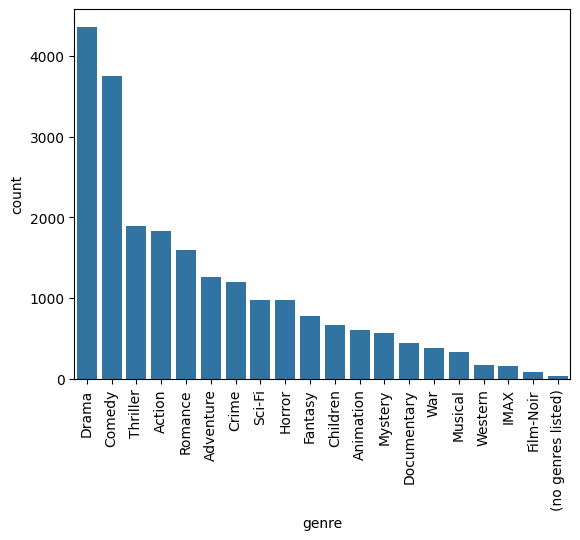

In [37]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

# Step 4: Data Pre-Processing

We will be using a technique called collaborative filtering to create recommendations for users. This method works on the assumption that people with similar preferences tend to like similar items.

Our first step is to convert the data into a user-item matrix, also referred to as a "utility" matrix. In this matrix, rows correspond to users and columns represent movies. One key advantage of collaborative filtering is that it doesn't require any specific information about the users or movies to make recommendations.

The `create_X()` function generates a sparse matrix along with four mapping dictionaries:


*   `user_mapper`: maps user id to user index
*   `movie_mapper`: maps movie id to movie index
*   `user_inv_mapper`: maps user index to user id
*   `movie_inv_mapper`: maps movie index to movie id

These dictionaries are essential as they help us determine which row or column of the utility matrix corresponds to each user or movie ID.

The resulting user-item matrix is a `scipy.sparse.csr_matrix`, which efficiently stores the data in a sparse format.

In [38]:
from scipy.sparse import csr_matrix

def create_X(df):
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [39]:
X.shape

(610, 9724)

**Evaluating sparsity**

We calculate sparsity by dividing the number of stored elements by the total number of possible elements in the matrix. The number of stored (non-empty) elements, denoted as nnz, represents the number of ratings available in our dataset.


In [40]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


`csr_matrix.nnz` counts the stored values in our sparse matrix, while the remaining cells are empty.

The cold start problem occurs when new users or movies appear in the matrix without any ratings. In the Movielens dataset, all users and movies have at least one rating, but it is generally helpful to identify users and movies with minimal interactions to address potential cold start issues.

In [41]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [42]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [43]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [44]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


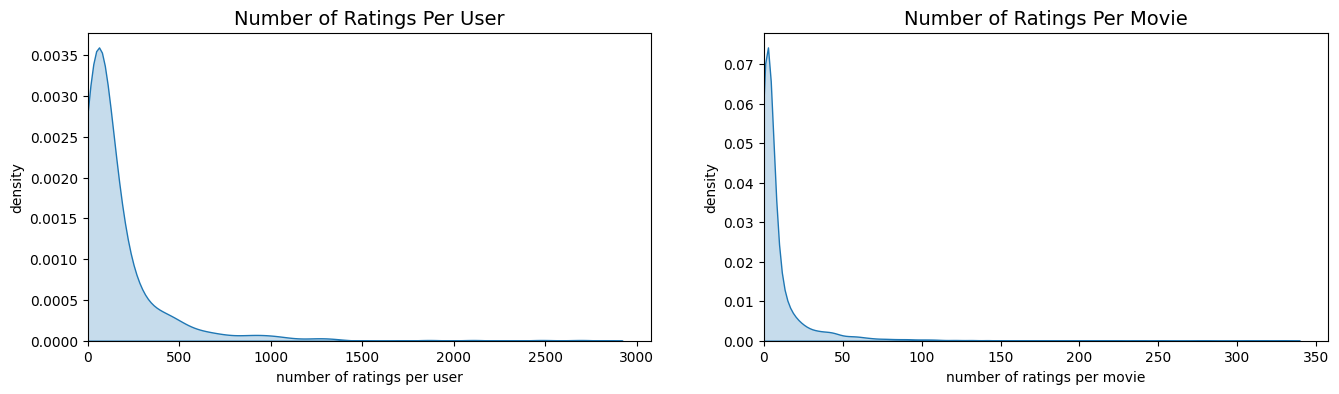

In [45]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

# Step 5: Collaborative filtering using k-Nearest Neighbors

We are going to find the *k* movies that have the most similar user engagement vectors for movie *i*.

In [46]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [47]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

In [63]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 500

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Mrs. Doubtfire (1993):
Pretty Woman (1990)
Lion King, The (1994)
Ghost (1990)
Speed (1994)
Jurassic Park (1993)
Forrest Gump (1994)
Home Alone (1990)
Mask, The (1994)
Sleepless in Seattle (1993)


The results above display the 10 movies most similar to Mrs Doubtfire. Many of these are family comedy films from the 1990s, which makes sense. It's important to note that these recommendations are based purely on user-item ratings, without considering movie features like genres.

# Step 6: Addressing the Cold-Start Problem
Collaborative filtering depends entirely on user-item interactions in the utility matrix. A challenge with this method is that new users or items without any interactions are left out of the recommendation system, a situation known as the cold-start problem. One solution is content-based filtering, which generates recommendations using features of users and items.

To implement this, we first need to transform the `genres` column into binary features. Each genre will have its own column in the dataframe, filled with either a 0 or 1.

In [64]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [65]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))

movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [66]:
movie_genres.head()

,Musical,Fantasy,Mystery,Adventure,Animation,IMAX,War,Children,Drama,Horror,Documentary,Action,Comedy,Crime,Romance,Thriller,Film-Noir,Sci-Fi,Western,(no genres listed)
0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [67]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


After passing the `movie_genres` dataframe into the `cosine_similarity()` function, we obtain a cosine similarity matrix with a shape of (number of movies, number of movies), where each entry represents the similarity between two movies based on their genres.

# Creating a Movie Finder Function
Suppose we want to find recommendations for movies similar to Jumanji. To retrieve results from our recommender, we must provide the exact title as it appears in our dataset.

In this case, Jumanji is listed as "Jumanji (1995)." If the title is misspelled or the release year is omitted, the recommender won't be able to recognize the intended movie.

To improve user experience, we can use the Python package fuzzywuzzy, which identifies the closest matching title to the input string. We'll create a function called `movie_finder()` that utilizes fuzzywuzzy's string matching algorithm to find the most similar title to what the user enters.

In [70]:
!pip install fuzzywuzzy

In [72]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [92]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

To obtain relevant recommendations for Jumanji, we first need to locate its index in the cosine similarity matrix. To determine which row corresponds to a specific movie, we can create a movie index mapper that links each movie title to its respective index in the matrix.

We can accomplish this by creating a dictionary called `movie_index`, where the keys are the movie titles and the values are their corresponding indices in the matrix.

In [79]:
movie_index = dict(zip(movies['title'], list(movies.index)))
index = movie_index[title]
print(f"Movie index for Jumanji: {index}")

Movie index for Jumanji: 1


With the help of the `movie_index` dictionary, we can identify that Jumanji is represented by index 1 in the matrix. Now, let's retrieve the top 10 most similar movies to Jumanji by accessing the corresponding row in the cosine similarity matrix and sorting the similarity scores in descending order.

In [81]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[index]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

The `similar_movies` array contains the indices of Jumanji's top 10 recommended movies. To get the corresponding movie titles, we can either:

1.   Create an inverse `movie_index` mapper, which maps indices back to movie titles.
2.   Use `.iloc` on the title column of the `movies` dataframe to directly access the titles based on the indices from `similar_movies`.

Either approach will allow us to retrieve the titles for the top 10 recommendations.

In [82]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


,title
53,"Indian in the Cupboard, The (1995)"
109,"NeverEnding Story III, The (1994)"
767,Escape to Witch Mountain (1975)
1514,Darby O'Gill and the Little People (1959)
1556,Return to Oz (1985)
1617,"NeverEnding Story, The (1984)"
1618,"NeverEnding Story II: The Next Chapter, The (1..."
1799,Santa Claus: The Movie (1985)
3574,Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075,"Chronicles of Narnia: The Lion, the Witch and ..."


These recommendations appear quite relevant and closely aligned with Jumanji. The first five movies are family-friendly films from the 90s.

To further test our recommender with different movie titles, we can streamline the process by combining all the steps into a single function. This function will take the movie title you're interested in and the number of recommendations you want to receive.

In [84]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    index = movie_index[title]
    sim_scores = list(enumerate(cosine_sim[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [90]:
get_content_based_recommendations('toy story', 5)

Because you watched Toy Story (1995):
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object


# Step 7: Dimensionality Reduction with Matrix Factorization
Matrix factorization (MF) is a linear algebra method used to reveal latent features that influence user-movie interactions. These features offer a more streamlined representation of user preferences and movie attributes. MF is especially effective for handling sparse datasets and can enhance the accuracy of recommendations. The technique works by decomposing the original user-item matrix into two smaller matrices:

*   user-factor matrix (n_users, k)
*   item-factor matrix (k, n_items)

In [86]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(9724, 20)

In [93]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Willy Wonka & the Chocolate Factory (1971)
Back to the Future (1985)
Forrest Gump (1994)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)


The results above show the movies most similar to Jumanji, generated using kNN on our "compressed" movie-factor matrix. We reduced the dimensionality to `n_components=20`, with each component representing a latent feature, such as a movie's genre.
